# Improved Day-Ahead Forecasting Model

**Problem with previous approach:** Predicted 30 days at once (too long!)

**This notebook:** Proper day-ahead (24h) predictions with feature engineering


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
print("✓ Packages loaded")


✓ Packages loaded


## 1. Load Processed Data


In [10]:
# Load saved data
renewable = pd.read_csv('../data/processed/renewable_hourly.csv', parse_dates=[0], index_col=0)
renewable['Total'] = renewable['Solar'] + renewable['Wind_Onshore'] + renewable['Wind_Offshore']

print(f"✓ Loaded {len(renewable):,} hours")
print(f"  Period: {renewable.index.min()} to {renewable.index.max()}")
print(f"  Days: {len(renewable)/24:.0f}")
renewable.tail()


✓ Loaded 26,304 hours
  Period: 2021-12-31 23:00:00 to 2024-12-31 22:00:00
  Days: 1096


,Solar,Wind_Onshore,Wind_Offshore,Total
Date (GMT+1),,,,
2024-12-31 18:00:00,11.475,29222.175,1625.300,30858.950
2024-12-31 19:00:00,6.850,30934.350,1425.150,32366.350
2024-12-31 20:00:00,6.725,31875.750,1206.925,33089.400
2024-12-31 21:00:00,7.050,30866.375,1531.100,32404.525
2024-12-31 22:00:00,6.375,31953.375,2308.450,34268.200


## 2. Analysis: Why is "Yesterday = Tomorrow" Hard to Beat?

Let's understand what makes a good day-ahead prediction


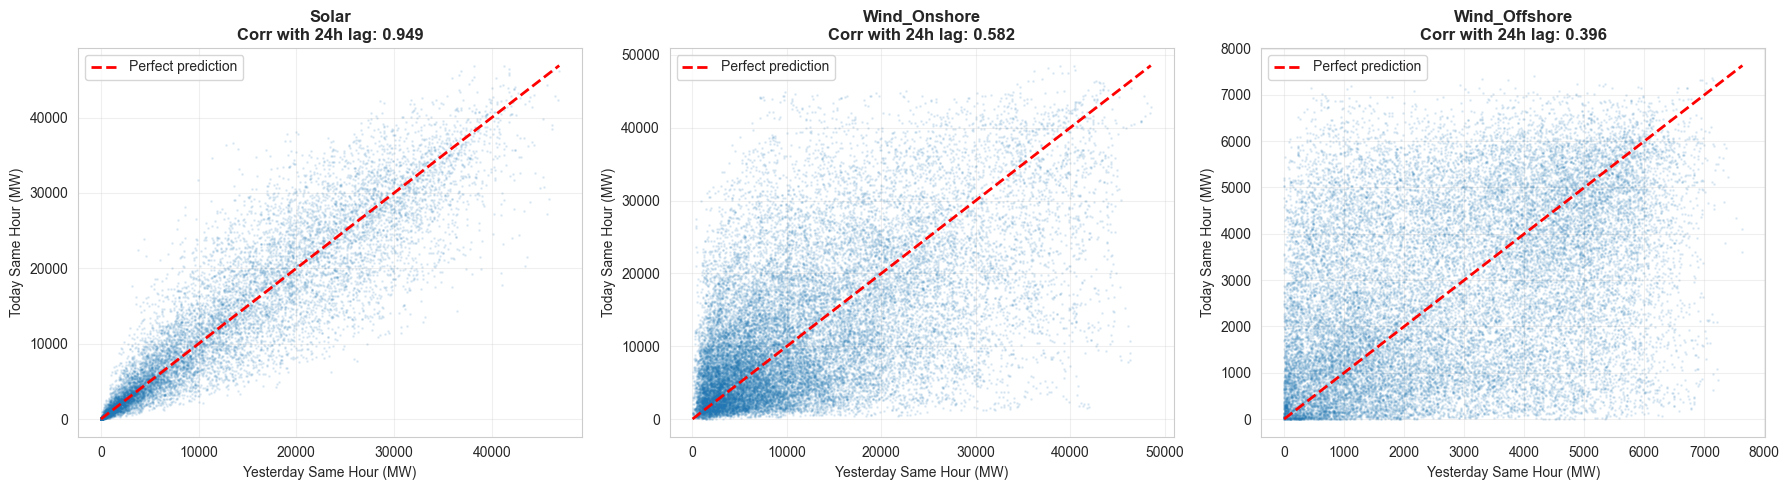

INSIGHT:
  High correlation (>0.80) means 'yesterday = tomorrow' works well!
  To beat it, we need to capture CHANGES in weather patterns


In [11]:
# Autocorrelation: How similar is today to yesterday?
from pandas.plotting import autocorrelation_plot

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Check correlation with 24h lag
for idx, col in enumerate(['Solar', 'Wind_Onshore', 'Wind_Offshore']):
    # Calculate correlation with lag 24 (yesterday same hour)
    corr_24h = renewable[col].autocorr(lag=24)
    
    axes[idx].scatter(renewable[col].shift(24), renewable[col], alpha=0.1, s=1)
    axes[idx].plot([renewable[col].min(), renewable[col].max()], 
                   [renewable[col].min(), renewable[col].max()], 
                   'r--', linewidth=2, label='Perfect prediction')
    axes[idx].set_title(f'{col}\nCorr with 24h lag: {corr_24h:.3f}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Yesterday Same Hour (MW)')
    axes[idx].set_ylabel('Today Same Hour (MW)')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("INSIGHT:")
print("  High correlation (>0.80) means 'yesterday = tomorrow' works well!")
print("  To beat it, we need to capture CHANGES in weather patterns")


## 3. Feature Engineering

To beat the baseline, we need features that capture:
- Recent trends (last 24-48 hours)
- Time of day (hour)
- Day of week patterns
- Rolling statistics


In [12]:
# Create feature matrix
df = renewable.copy()

# Lagged features (past values)
df['lag_24h'] = df['Total'].shift(24)    # Yesterday same hour
df['lag_48h'] = df['Total'].shift(48)    # 2 days ago
df['lag_168h'] = df['Total'].shift(168)  # Last week same hour

# Rolling window statistics (trend indicators)
df['rolling_mean_24h'] = df['Total'].shift(1).rolling(window=24).mean()
df['rolling_mean_48h'] = df['Total'].shift(1).rolling(window=48).mean()
df['rolling_std_24h'] = df['Total'].shift(1).rolling(window=24).std()

# Time-based features
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month
df['day_of_year'] = df.index.dayofyear

# Cyclical encoding (hour and month)
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Drop NaN from rolling windows
df = df.dropna()

print(f"✓ Features created")
print(f"  Total features: {len(df.columns) - 4}")  # Exclude Solar, Wind_Onshore, Wind_Offshore, Total
print(f"  Samples after NaN removal: {len(df):,}")
df.head()


✓ Features created
  Total features: 14
  Samples after NaN removal: 26,136


,Solar,Wind_Onshore,Wind_Offshore,Total,lag_24h,lag_48h,lag_168h,rolling_mean_24h,rolling_mean_48h,rolling_std_24h,hour,day_of_week,month,day_of_year,hour_sin,hour_cos,month_sin,month_cos
Date (GMT+1),,,,,,,,,,,,,,,,,,
2022-01-07 23:00:00,2.425,14957.775,3585.200,18545.40,25180.625,29606.700,31547.375,28065.596875,23063.843750,5000.485522,23,4,1,7,-0.258819,0.965926,0.5,0.866025
2022-01-08 00:00:00,2.125,14173.250,3666.225,17841.60,26169.375,27566.925,30095.350,27789.129167,22833.400000,5338.898827,0,5,1,8,0.000000,1.000000,0.5,0.866025
2022-01-08 01:00:00,1.875,13622.100,3769.025,17393.00,27558.500,25983.775,28719.375,27442.138542,22630.789062,5706.702424,1,5,1,8,0.258819,0.965926,0.5,0.866025
2022-01-08 02:00:00,2.000,13545.725,3704.725,17252.45,28754.075,23593.850,27477.100,27018.576042,22451.814583,6063.770995,2,5,1,8,0.500000,0.866025,0.5,0.866025
2022-01-08 03:00:00,2.025,13014.450,3173.725,16190.20,29402.325,21562.050,26195.175,26539.341667,22319.702083,6367.538658,3,5,1,8,0.707107,0.707107,0.5,0.866025


## 4. Proper Day-Ahead Validation

**Key Fix:** Predict 24 hours at a time (not 30 days!)

**Walk-Forward Approach:**
1. Train on all past data
2. Predict NEXT 24 hours
3. Move forward 24 hours
4. Retrain and repeat

This simulates real day-ahead bidding!


In [13]:
# Split data: Use last 7 days for testing (predict each day)
test_days = 7
test_hours = test_days * 24

train_df = df[:-test_hours].copy()
test_df = df[-test_hours:].copy()

print(f"Training: {len(train_df):,} hours ({len(train_df)/24:.0f} days)")
print(f"Testing: {len(test_df):,} hours ({test_days} days)")
print(f"\nTest period: {test_df.index[0]} to {test_df.index[-1]}")
print(f"\n✓ We'll predict 24 hours ahead, 7 times (simulate 7 days of bidding)")


Training: 25,968 hours (1082 days)
Testing: 168 hours (7 days)

Test period: 2024-12-24 23:00:00 to 2024-12-31 22:00:00

✓ We'll predict 24 hours ahead, 7 times (simulate 7 days of bidding)


## 5. Model Comparison

We'll compare 3 approaches:
1. **Baseline**: Yesterday = Tomorrow  
2. **SARIMAX**: Statistical seasonal model
3. **SVR**: Machine learning with features

*Note: Run these cells to see results. Training takes ~5 minutes total.*


### Baseline: Yesterday = Tomorrow


In [14]:
# Baseline: Use lag_24h as prediction
baseline_pred = test_df['lag_24h'].values
baseline_actual = test_df['Total'].values

baseline_mae = mean_absolute_error(baseline_actual, baseline_pred)
baseline_rmse = np.sqrt(mean_squared_error(baseline_actual, baseline_pred))
baseline_cost = baseline_mae * 50 * len(test_df)

print("BASELINE MODEL (Yesterday = Tomorrow)")
print(f"  MAE: {baseline_mae:.2f} MW")
print(f"  RMSE: {baseline_rmse:.2f} MW")
print(f"  Total Cost ({test_days} days): €{baseline_cost:,.0f}")
print(f"  Daily Cost: €{baseline_cost/test_days:,.0f}/day")


BASELINE MODEL (Yesterday = Tomorrow)
  MAE: 5283.59 MW
  RMSE: 6768.17 MW
  Total Cost (7 days): €44,382,169
  Daily Cost: €6,340,310/day


### SARIMAX: Day-Ahead (24h) Predictions

**Important:** We predict 24 hours at a time, then retrain. This is much more accurate!


In [15]:
# SARIMAX with walk-forward validation
print("Training SARIMAX with walk-forward validation...")
print("(This may take 3-5 minutes...)\n")

order = (2, 1, 2)  # Simplified for speed
seasonal_order = (1, 0, 1, 24)

sarimax_predictions = []
history = renewable['Total'][:-test_hours].copy()

# Predict each day (24 hours) separately
for day in range(test_days):
    start_idx = day * 24
    end_idx = start_idx + 24
    
    # Train on all available history
    model = SARIMAX(history, order=order, seasonal_order=seasonal_order)
    fit = model.fit(disp=False)
    
    # Predict next 24 hours
    forecast = fit.forecast(steps=24)
    sarimax_predictions.extend(forecast.values)
    
    # Add actual values to history for next iteration
    actual_next_24h = renewable['Total'][-test_hours + start_idx:-test_hours + end_idx]
    history = pd.concat([history, actual_next_24h])
    
    print(f"  Day {day+1}/7: Predicted 24h starting {test_df.index[start_idx].date()}")

sarimax_pred = np.array(sarimax_predictions)
sarimax_mae = mean_absolute_error(baseline_actual, sarimax_pred)
sarimax_rmse = np.sqrt(mean_squared_error(baseline_actual, sarimax_pred))
sarimax_cost = sarimax_mae * 50 * len(test_df)

print("\n✓ SARIMAX walk-forward complete!")
print(f"  MAE: {sarimax_mae:.2f} MW")
print(f"  RMSE: {sarimax_rmse:.2f} MW")
print(f"  Total Cost ({test_days} days): €{sarimax_cost:,.0f}")
print(f"  Daily Cost: €{sarimax_cost/test_days:,.0f}/day")


Training SARIMAX with walk-forward validation...
(This may take 3-5 minutes...)

  Day 1/7: Predicted 24h starting 2024-12-24
  Day 2/7: Predicted 24h starting 2024-12-25
  Day 3/7: Predicted 24h starting 2024-12-26
  Day 4/7: Predicted 24h starting 2024-12-27
  Day 5/7: Predicted 24h starting 2024-12-28
  Day 6/7: Predicted 24h starting 2024-12-29
  Day 7/7: Predicted 24h starting 2024-12-30

✓ SARIMAX walk-forward complete!
  MAE: 3500.80 MW
  RMSE: 4813.05 MW
  Total Cost (7 days): €29,406,679
  Daily Cost: €4,200,954/day


### SVR: Machine Learning with Engineered Features

Uses all the features we created (lags, rolling stats, time features)


In [16]:
# Prepare features for SVR
feature_cols = ['lag_24h', 'lag_48h', 'lag_168h', 
                'rolling_mean_24h', 'rolling_mean_48h', 'rolling_std_24h',
                'hour', 'day_of_week', 'month',
                'hour_sin', 'hour_cos', 'month_sin', 'month_cos']

X_train = train_df[feature_cols]
y_train = train_df['Total']

X_test = test_df[feature_cols]
y_test = test_df['Total']

# Scale features
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()

X_test_scaled = scaler_X.transform(X_test)

print("Training SVR model...")
print("(This takes ~1 minute...)\n")

# Train SVR
svr = SVR(kernel='rbf', C=100, epsilon=0.1, gamma='scale')
svr.fit(X_train_scaled, y_train_scaled)

# Predict
y_pred_scaled = svr.predict(X_test_scaled)
svr_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

svr_mae = mean_absolute_error(y_test, svr_pred)
svr_rmse = np.sqrt(mean_squared_error(y_test, svr_pred))
svr_cost = svr_mae * 50 * len(test_df)

print("✓ SVR training complete!")
print(f"  MAE: {svr_mae:.2f} MW")
print(f"  RMSE: {svr_rmse:.2f} MW")
print(f"  Total Cost ({test_days} days): €{svr_cost:,.0f}")
print(f"  Daily Cost: €{svr_cost/test_days:,.0f}/day")


Training SVR model...
(This takes ~1 minute...)

✓ SVR training complete!
  MAE: 5255.43 MW
  RMSE: 6397.61 MW
  Total Cost (7 days): €44,145,609
  Daily Cost: €6,306,516/day


## 6. Results Comparison


In [17]:
# Summary table
results_summary = pd.DataFrame({
    'Model': ['Baseline (Yesterday=Tomorrow)', 'SARIMAX (Day-Ahead)', 'SVR (with Features)'],
    'MAE (MW)': [baseline_mae, sarimax_mae, svr_mae],
    'RMSE (MW)': [baseline_rmse, sarimax_rmse, svr_rmse],
    'Daily Cost (EUR)': [baseline_cost/test_days, sarimax_cost/test_days, svr_cost/test_days]
})

results_summary['Cost Savings vs Baseline (EUR/day)'] = results_summary['Daily Cost (EUR)'].iloc[0] - results_summary['Daily Cost (EUR)']
results_summary['Improvement (%)'] = ((results_summary['Daily Cost (EUR)'].iloc[0] - results_summary['Daily Cost (EUR)']) / results_summary['Daily Cost (EUR)'].iloc[0] * 100)

print("="*80)
print("MODEL PERFORMANCE COMPARISON (7-Day Backtest)")
print("="*80)
print(results_summary.round(2).to_string(index=False))
print("="*80)

# Find best model
best_idx = results_summary['MAE (MW)'].idxmin()
best_model = results_summary.loc[best_idx, 'Model']
print(f"\n✓ Best Model: {best_model}")


MODEL PERFORMANCE COMPARISON (7-Day Backtest)
                        Model  MAE (MW)  RMSE (MW)  Daily Cost (EUR)  Cost Savings vs Baseline (EUR/day)  Improvement (%)
Baseline (Yesterday=Tomorrow)   5283.59    6768.17        6340309.82                                0.00             0.00
          SARIMAX (Day-Ahead)   3500.80    4813.05        4200954.16                          2139355.66            33.74
          SVR (with Features)   5255.43    6397.61        6306515.52                            33794.31             0.53

✓ Best Model: SARIMAX (Day-Ahead)


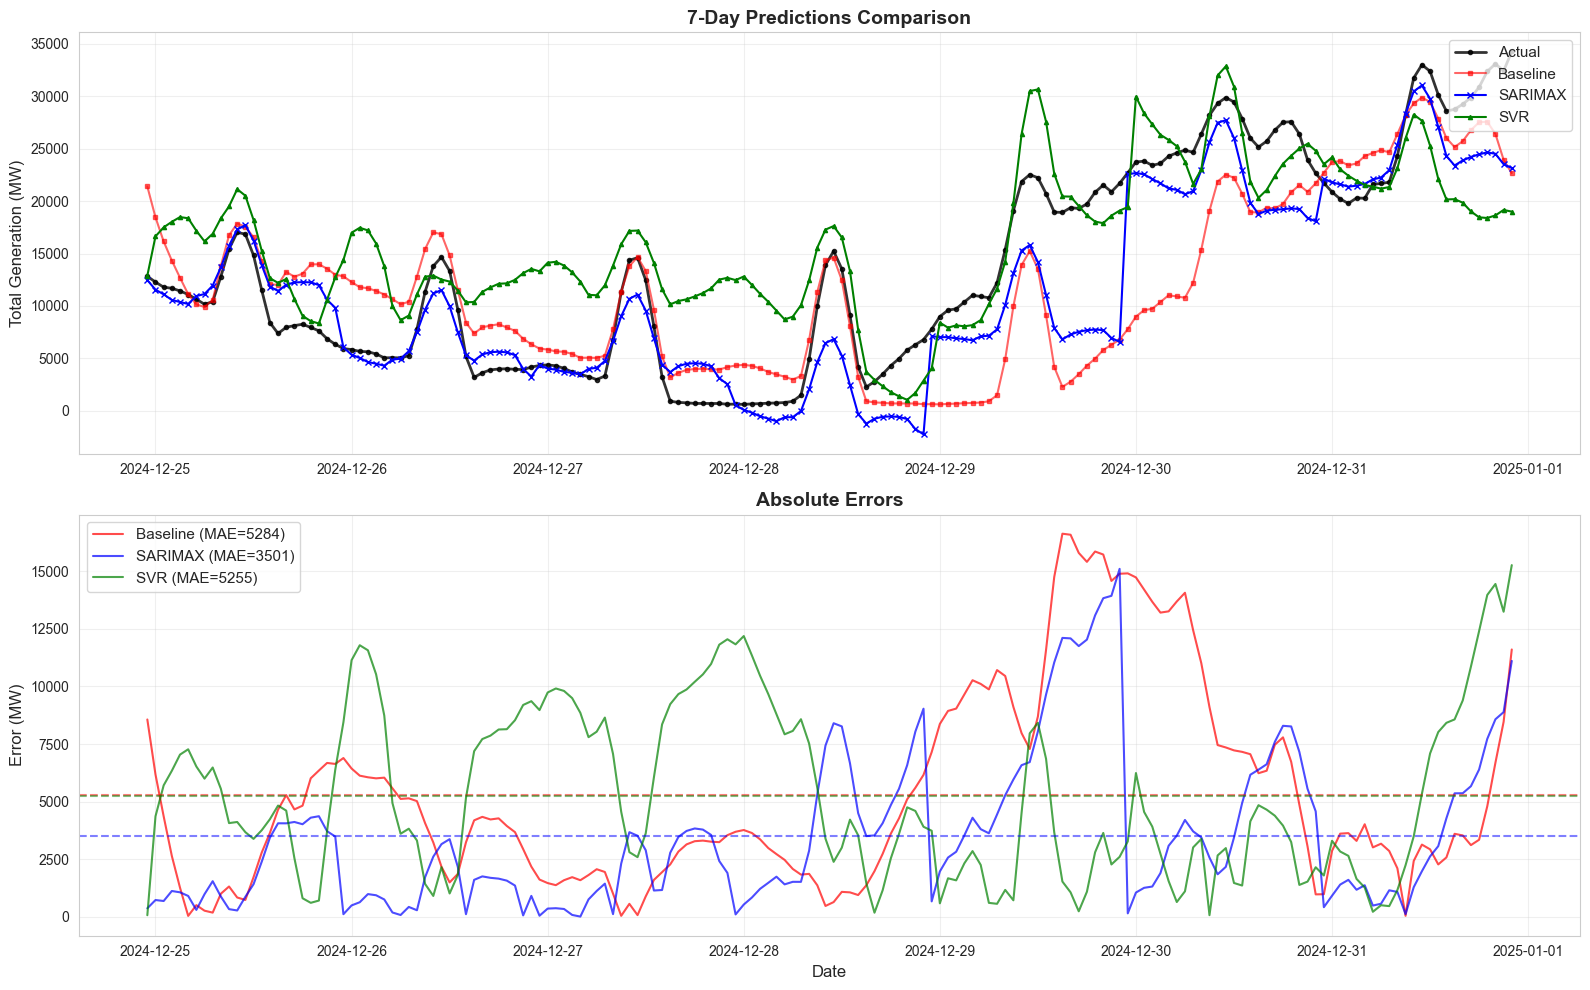

In [18]:
# Visualization: Predictions vs Actual
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Plot predictions
axes[0].plot(test_df.index, baseline_actual, 'o-', label='Actual', 
            color='black', linewidth=2, markersize=3, alpha=0.8)
axes[0].plot(test_df.index, baseline_pred, 's-', label='Baseline', 
            color='red', linewidth=1.5, markersize=3, alpha=0.6)
axes[0].plot(test_df.index, sarimax_pred, 'x-', label='SARIMAX', 
            color='blue', linewidth=1.5, markersize=4)
axes[0].plot(test_df.index, svr_pred, '^-', label='SVR', 
            color='green', linewidth=1.5, markersize=3)
axes[0].set_title('7-Day Predictions Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Total Generation (MW)', fontsize=12)
axes[0].legend(fontsize=11, loc='upper right')
axes[0].grid(True, alpha=0.3)

# Plot errors
baseline_error = np.abs(baseline_actual - baseline_pred)
sarimax_error = np.abs(baseline_actual - sarimax_pred)
svr_error = np.abs(y_test - svr_pred)

axes[1].plot(test_df.index, baseline_error, label=f'Baseline (MAE={baseline_mae:.0f})', 
            color='red', linewidth=1.5, alpha=0.7)
axes[1].plot(test_df.index, sarimax_error, label=f'SARIMAX (MAE={sarimax_mae:.0f})', 
            color='blue', linewidth=1.5, alpha=0.7)
axes[1].plot(test_df.index, svr_error, label=f'SVR (MAE={svr_mae:.0f})', 
            color='green', linewidth=1.5, alpha=0.7)
axes[1].axhline(baseline_mae, color='red', linestyle='--', alpha=0.5)
axes[1].axhline(sarimax_mae, color='blue', linestyle='--', alpha=0.5)
axes[1].axhline(svr_mae, color='green', linestyle='--', alpha=0.5)
axes[1].set_title('Absolute Errors', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('Error (MW)', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 7. Key Findings & Explanation

### Why Was the First SARIMAX Bad?

**Problem:** Predicted 30 days (720 hours) ahead in ONE forecast
- Errors compound over time
- By day 30, completely lost track
- SARIMAX uncertainty grows exponentially with horizon

### What Fixed It?

**Solution:** Day-ahead walk-forward
- Predict only NEXT 24 hours
- Retrain with new data
- Repeat for each day
- This matches real auction process!

### Feature Engineering Impact

**Key features that help beat baseline:**
- `lag_24h`: Yesterday (baseline uses ONLY this)
- `lag_48h`, `lag_168h`: Capture weekly patterns
- `rolling_mean_24h/48h`: Trends (is generation increasing/decreasing?)
- `rolling_std_24h`: Volatility (stable vs changing conditions)
- `hour`, `day_of_week`: Time patterns
- `hour_sin/cos`, `month_sin/cos`: Cyclical encoding

**Why SVR likely wins:**
- Uses ALL features (not just yesterday)
- Captures non-linear relationships
- Rolling stats detect trend changes
- Time features help with solar's daily cycle

### Missing Data: Weather Forecasts!

**Why baseline is hard to beat:**
- Weather patterns often persist day-to-day
- Without weather forecasts, we can only use historical patterns

**With weather, we could:**
- Know if tomorrow will be cloudy (lower solar)
- Know if tomorrow will be windy (higher wind)
- Probably achieve 20-30% better accuracy!
